In [5]:
import csv
import sys
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

#from scipy import stats, integrate
#from scipy import misc
import scipy.ndimage as ndi
from scipy.spatial import distance
from itertools import cycle


from mpl_toolkits.mplot3d import Axes3D
from __future__ import division

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data
from matplotlib.lines import Line2D

global Fixations_person

%matplotlib inline

np.set_printoptions(threshold='nan')

#sns.set(color_codes=True)

plt.close('all')

width = 20
height = 20
time= '10'


# 21 images
# imageName_array =['OverParis', 'outdoor8', 'BellagioHotelLobby', 'theBeach', 'indoor3', 'outdoor2', 'indoor4', 'outdoor18', 'The_Porch', 'outdoor16', 'indoor5', 'outdoor6', 'outdoor17', 'CathedraledeBordeaux', 'outdoor5', 'outdoor4', 'indoor7', 'outdoor9', 'outdoor1', 'indoor6', 'outdoor15']
# imageLabels = ['Paris', 'Desert', 'Lobby', 'Beach', 'Office', 'Bay', 'Wed', 'Snow', 'Porch', 'Pool', 'Talk', 'Hike', 'Game', 'Church', 'Cows', 'Kayak', 'Gallery', 'Ski', 'Fair', 'Show', 'Concert']

# 16 participants
#persons_array=["1", "2", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "15", "16", "17", "18"] # 20s 
#persons_array=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"] # 10s

imageName_array =['outdoor1']
persons_array=["10"] 




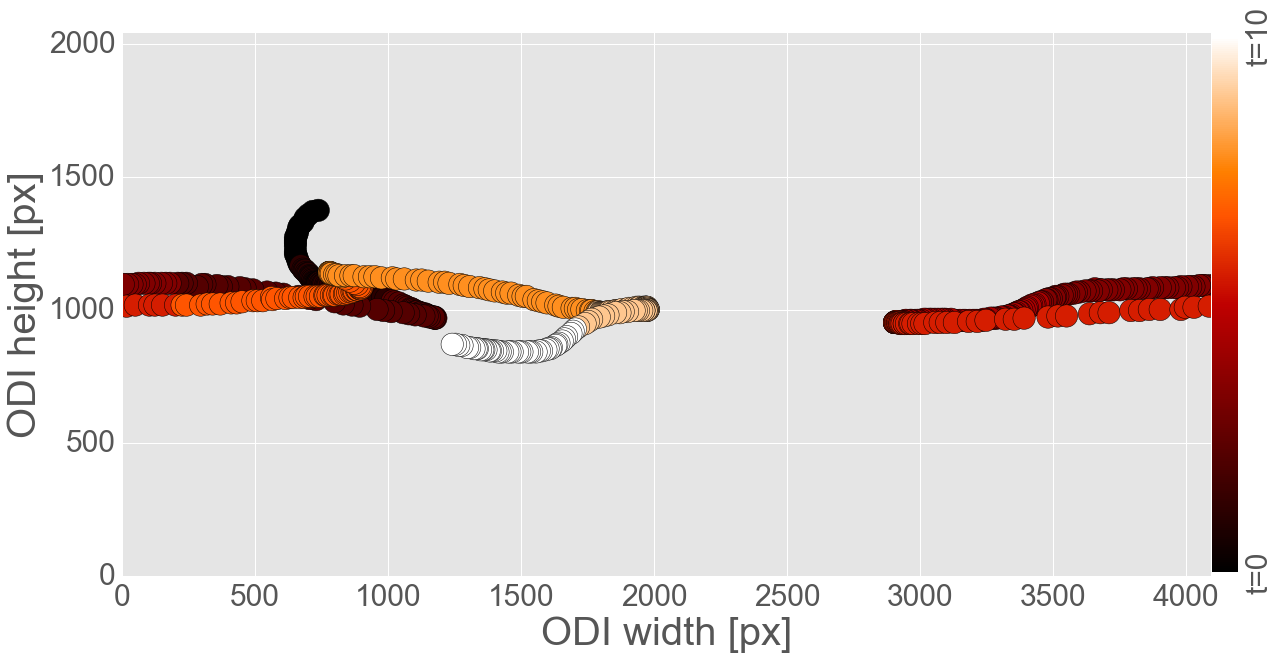

In [27]:
array_x_extended = np.array([])
array_y_extended = np.array([])
distVisited =[]

w, h = len(persons_array), len(imageName_array) 
distVisited_matrix =[[0 for x in range(w)] for y in range(h)]

imageTime = []
cumDistVisited_array = []

for image_index in range(len(imageName_array)):
#for image_index in range(1):

    savedImageName = imageName_array[image_index]
    imageName = imageName_array[image_index]
    
    cumDistVisited = 0
    cumDistVisited_index = 0
    
    GroupedFixations = np.zeros((501, 1001))
    
    for person_idx in range(len(persons_array)) :
        person = persons_array[person_idx]
        
        array_x=[]
        array_y=[]
        array_time=[]

        array_x_org=[]
        array_y_org=[]
        count_row=0
        
        RegisteredPoints_person= np.zeros((501, 1001), dtype=object) # Created to have a heat map per person
        ProbMatrix_person= np.zeros((501, 1001), dtype=np.int) # Created to have a heat map per person

        
        #***********************************************************************
        # Read the csv file and store in arrays (x,y) values
        #***********************************************************************

        #f = open('stats_' + person + '.csv', 'rt')
        
        f = open(('statsSecond1_showingTime_' + time + '000_participant_' + person + '.csv'), 'rt')
        
        try:
            reader = csv.reader(f)
            
            
            for row in reader:
                
                if row != []:
     
                    if row[1] == imageName:
                        count_row += 1
                        #print count_row
                        if count_row == 1:
                            firstTime = np.around(float(row[2]))
                        if count_row > 40: # to don't consider the first fixation (1s)
                        # if count_row > 40 and count_row < 600: # to don't consider the first fixation (1s), nor the last 5s
                    
                            array_x_org.append(np.around(float(row[3]), decimals=2))
                            array_y_org.append(np.around(float(row[4]), decimals=2))
                    
                            array_x.append(int((np.around(float(row[3]), decimals=2)*100) + 500)) # Depends on the size of the equirectangular image
                            array_y.append(int((np.around(float(row[4]), decimals=2)*100) + 250))
                    
                            array_time.append(np.around(float(row[2])))

        finally:
            f.close()

        array_x = np.array(array_x)  
        array_y = np.array(array_y)
        array_time = np.array(array_time)

        max_x =  np.max(array_x, axis=0)
        min_x =  np.min(array_x, axis=0)
        

        #max_time =  np.max(array_time, axis=0)
        #min_time =  np.min(array_time, axis=0)

        array_x_extended = np.append(array_x_extended, array_x)
        array_y_extended = np.append(array_y_extended, array_y)
        
        
        #*********************************************************************************
        # Calculate distance visited by the users
        #*********************************************************************************
                
        array_xSorted = np.sort(array_x)

        maxDiff = (999 - array_xSorted[-1]) + (array_xSorted[0] - 0)
        pointA = array_xSorted[0] 
        pointB = array_xSorted[-1]
        entered = 0
        #print(maxDiff, pointA, pointB)

        for i in range(len(array_xSorted) - 1):
            diff= array_xSorted[i+1] - array_xSorted[i]
            if maxDiff < diff:
                maxDiff = diff
                pointA = array_xSorted[i]
                pointB = array_xSorted[i+1]
                entered = 1;
        
        if len(persons_array) > 1:
            
            #print(image_index,person_idx, len(distVisited_matrix), len(distVisited_matrix[0]) )
            
            if cumDistVisited_index == len(persons_array) - 1: # means next will be a new image :)
                if (entered == 1) :
                    cumDistVisited = cumDistVisited + (pointA + (1000 - pointB))
                    distVisited_matrix[image_index][person_idx] = pointA + (1000 - pointB)
                else:
                    cumDistVisited = cumDistVisited + (pointB - pointA)
                    distVisited_matrix[image_index][person_idx] = (pointB - pointA)
                cumDistVisited_array = np.append(cumDistVisited_array, cumDistVisited)

            
            else:
                cumDistVisited_index += 1
                if (entered == 1) :
                    cumDistVisited = cumDistVisited + (pointA + (1000 - pointB))
                    distVisited_matrix[image_index][person_idx] = pointA + (1000 - pointB)
                else:
                    cumDistVisited = cumDistVisited + (pointB - pointA)
                    distVisited_matrix[image_index][person_idx] = (pointB - pointA)

        if len(persons_array) == 1:
            imageTime = np.append(imageTime, firstTime ) # In order to have an ordered (regarding presentation time) plot 

            if (entered == 1) :
                distVisited = np.append(distVisited, (pointA + (1000 - pointB)))
                #print (savedImageName, 0, pointA, pointB, 1000, distVisited)
            else:
                distVisited = np.append(distVisited,(pointB - pointA)) 
                #print (savedImageName, pointA, pointB, distVisited)
            
        
        #*********************************************************************************
        # Assigns +1 in a position (x,y) detected
        #*********************************************************************************

        for i in range(len(array_x)):
            x = array_x[i]
            y = array_y[i]
            ProbMatrix_person[y, x] += 1

            RegisteredPoints_person[y, x] = np.append(RegisteredPoints_person[y, x], array_time[i])
        

        #************************************************************************************************  
        #******************************************** DBSCAN ********************************************
        #                                       Looking for clusters
        #************************************************************************************************
        
        ClusterId = 2 # First ClusterId
        
        Fixations_person = np.zeros((501, 1001)) # Created to have a heat map per person
        for i in range(501):
            for j in range(1001):
                point = Point(i, j, RegisteredPoints_person[i,j])
                
                if point.times.size > 1: # Meaning, it was a visited point
                    
                    # point.ClId == 0 Means unclassified
                    xnew = i - 250 # I need the point centered in 0
                    minPts = 12
                    eps = np.rint(6 * (1 / (np.cos(xnew/250 * np.pi/2)))) # Distance - rounded to the closest integer

                    if (point.posX > eps and  point.posX < (501 - eps) and point.posY > eps and point.posY < (1001 - eps)):
                     
                        #print (xnew, (137/250 * np.pi/2), np.cos(0.86079638708), eps)
                       
                        if ExpandCluster(RegisteredPoints_person, point, int(eps), minPts, ClusterId):
                            ClusterId += 1

        #************************************************************************************************  
        #********************************* Post-processing per person ***********************************

        # Expand each fixation
        #radio= 5
        #Fixations_person = ExpandFixation(Fixations_person, radio)
        #PlotFixations_SaliencyMaps(Fixations_person, savedImageName, person, time)
        PlotTemporalPath(array_x, array_y, array_time, savedImageName, person, time)
        
        # Add it to the grouped fixations
        GroupedFixations += Fixations_person

        
#     # Average group fixations
    GroupedFixations = GroupedFixations/len(persons_array)
#    PlotFixations_SaliencyMaps(GroupedFixations, savedImageName, '0', time)

    
#************************************************************************************************  
# Only in the case of one participant
#************************************************************************************************  
#if len(persons_array) == 1:

#     new_imageName_array =[]
#     new_distVisited = []

#     imageTime = np.array(imageTime)
#     sortedImageTime = np.sort(imageTime)

#     st = set(sortedImageTime)

#     for x in sortedImageTime: 
#         if x in imageTime:
#             index, = np.where( imageTime==x )
#             new_imageName_array.append(imageName_array[index])
#             new_distVisited.append(distVisited[index])

#     new_distVisited = np.array(new_distVisited)

#     # print (imageTime)
#     # print (sortedImageTime)

#     # print (imageName_array)
#     # print (new_imageName_array)
#     # print (distVisited)
#     # print (new_distVisited)

#     y = distVisited
#     x = range(len(imageName_array))
#     labels = imageName_array

#     y_new = new_distVisited
#     x_new = range(len(new_imageName_array))
#     labels_new = new_imageName_array


#     # Bar plot for individual Navigation Time

#     b1= plt.bar(x, y)
#     # You can specify a rotation for the tick labels in degrees or with keywords.
#     plt.ylim(0, 1000)
#     plt.xticks(x, labels, rotation='vertical')
#     # Pad margins so that markers don't get clipped by the axes
#     plt.margins(0.2)
#     # Tweak spacing to prevent clipping of tick-labels
#     plt.subplots_adjust(bottom=0.15)
#     plt.show()
#     plt.tight_layout()
#     # plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/10s/NavigationTime_' + person +'.png')


#     plt.close('all')
#     plt.clf()

    # Bar plot for Ordered(presentation) individual Navigation Time

    # b2 = plt.bar(x_new, y_new)
    # #b2.[0].set_color('r')
    # plt.ylim(0, 1000)
    # plt.xticks(x_new, labels_new, rotation='vertical')
    # plt.margins(0.2)
    # plt.subplots_adjust(bottom=0.15)
    # #plt.show()
    # plt.tight_layout()
    # plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/10s/OrderedNavigationTime_' + person +'.png')
#************************************************************************************************  
if len(persons_array) > 1:
    cumDistVisited_array = np.array(cumDistVisited_array)
    
    #y = np.array(cumDistVisited_array/len(persons_array)) # For mean value
    y = np.median(distVisited_matrix, 1) # For median value
    x = range(len(imageName_array))
    labels = imageName_array
    
    
        
    # calculate std 
    # For each image there are X participants
    std=[]
    for i in range(len(imageName_array)):
        indDist = np.array(distVisited_matrix[i])
        diff_std= np.power((y[i] - indDist), 2) 
        std = np.append(std, np.sqrt(np.sum(diff_std)/len(persons_array)) )
        
    y_mad = mad(distVisited_matrix, 1) # Median absolute deviation
    
    print('std', std)
    print('dist', y)
    print ('mad', y_mad)

#     plt.bar(x, y)
#     plt.ylim(0, 1000)
#     plt.xticks(x, labels, rotation='vertical')
#     plt.margins(0.2)
#     plt.subplots_adjust(bottom=0.15)
#     plt.tight_layout()
    
    
    #plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/' + time + 's/CumulatedNavigationTime.png')


In [26]:
def PlotTemporalPath(array_x, array_y, array_time, savedImageName, person, time):

#************************************************************************************************  
#*******************  Plot the the temporal path of the user over the image  ********************
# Only valid if plotting for one user, meaning persons_array has only one component
#************************************************************************************************  
    max_time =  np.max(array_time, axis=0)
    min_time =  np.min(array_time, axis=0)
    
    plt.style.use('ggplot') 
    #plt.rcParams['axes.facecolor']='whitesmoke'
    
    
    plt.figure(figsize=(width, height))
    cm_plot2 = plt.cm.get_cmap('gist_heat')
    z = array_time
    sc = plt.scatter(array_x*4.096, array_y*4.096, c=z, edgecolors='black', vmin=min_time, vmax=max_time, s=500, cmap=cm_plot2)
    plt.xlim(0, 4096)
    plt.ylim(0, 2048)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('ODI width [px]', fontsize=40)
    plt.ylabel('ODI height [px]',fontsize=40)
    plt.gca().set_aspect('equal', adjustable='box')

    cb= plt.colorbar(sc,ticks=[299,308],fraction=0.024, pad=0.00)
    #cb.set_ticks([])
    #cb.set_ticklabels(['t=0', 't=10'])
    cb.ax.set_yticklabels(['t=0', 't=10'], rotation=90, fontsize=30)
    plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/TimeSequence_' + savedImageName + '_' + person +'.pdf',bbox_inches='tight')

    
    #plt.show()

In [7]:
# Compute *Median Absolute Deviation* of an array along given axis.

def mad(a, axis):

    med = np.median(a, axis=axis, keepdims=True)
    return np.median(np.absolute(a - med), axis=axis)  # MAD along given axis


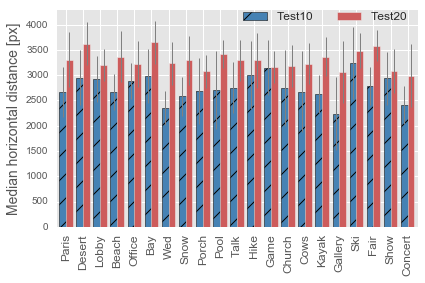

In [3]:
#Stacked bar plot

N = len(imageName_array)
labels = imageLabels

colors = np.array(['steelblue', 'indianred', 'olivedrab','darkorange',  'magenta', 'cornflowerblue', 'magenta', 'salmon'])  
markers = np.array([">", "o", "s", "D", "d", "p"])

## Mean values
# tenSecondsDistance = np.array([627.4,  697.33333333,  660.2,  702.26666667,
#         660.4,  691.26666667,  599.73333333,  632.46666667,
#         675.06666667,  659.46666667,  679.26666667,  738.86666667,
#         750.,  648.8,  658.2,  636.4,
#         564.73333333,  732.6,  656.66666667,  706.86666667,
#         573.33333333])* 4.096

# twentySecondsDistance = np.array([762.25  ,  839.8125,  750.8125,  815.25  ,  758.125 ,  829.625 ,
#         762.375 ,  773.75  ,  742.5625,  830.9375,  788.75  ,  828.4375,
#         783.125 ,  770.3125,  791.125 ,  825.8125,  759.1875,  828.6875,
#         868.75  ,  770.1875,  725.375 ])* 4.096

# #standard deviation std
# tenSecondsStd = np.array([235.59366149,  194.74895521,  141.71106755,  168.16439047,
#         165.54185775,  151.39373244,  150.5693491 ,  165.41578589,
#         189.88855211,  222.40259791,  189.98016271,  197.51046105,
#         160.76110641,  194.41954634,  190.09653688,  171.97085024,
#         185.05331364,  207.79310223,  148.22445442,  158.71604274,
#         156.62424958])* 4.096
# twentySecondsStd = np.array([ 187.61113373,  138.67417692,  115.71258507,  131.02790733,
#         175.85003376,  150.30089612,  158.01142166,  173.62513499,
#         160.71596403,  123.10436058,  124.40181872,  132.62304134,
#         147.70912083,  131.14148788,  150.23434819,  103.16020233,
#         174.59711436,  141.67644421,  103.59928812,  145.76960363,
#         181.21184943])* 4.096


# Median value

tenSecondsDistance = np.array([651.5,  721. ,  713. ,  652. ,  703. ,  729. ,  574. ,  631. ,
        656.5,  662.5,  671. ,  733.5,  769.5,  670.5,  652.5,  643. ,
        546.5,  789.5,  681. ,  718. ,  587. ])* 4.096

twentySecondsDistance = np.array([808. ,  883.5,  781. ,  821.5,  786.5,  891. ,  789. ,  805. ,
        751. ,  836. ,  805. ,  804. ,  772. ,  776. ,  788.5,  822.5,
        749. ,  850.5,  874.5,  752. ,  730.5])* 4.096

#meadian absolute deviation mad
tenSecondsStd = np.array([119. ,  131. ,  110. ,   86.5,   86.5,  129. ,   80. ,   94. ,
        158.5,  188.5,  123.5,  164. ,  135. ,  183. ,  194.5,   92.5,
        177.5,  173.5,   93. ,  128. ,   92.5])* 4.096
twentySecondsStd = np.array([134.5,  104. ,   78. ,  124. ,  110.5,  103.5,  105. ,  118. ,
         79. ,   68.5,   99.5,  134.5,   76. ,  100. ,   97.5,   93. ,
        149. ,   85. ,   74.5,  105.5,  151.])* 4.096



ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, tenSecondsDistance, width, color='steelblue', yerr=tenSecondsStd)
# p2 = plt.bar(ind, twentySecondsDistance, width, color='indianred', bottom=tenSecondsDistance, yerr=twentySecondsStd)

# plt.ylabel('Expected horizontal distance')
# #plt.title('Scores by group and gender')
# plt.xticks(ind, labels, rotation='vertical')
# plt.yticks(np.arange(0, 2000, 200))
# plt.legend((p1[0], p2[0]), ('10 s', '20 s'))

# plt.show()



fig = plt.figure()
ax = fig.add_subplot(111)



#bar plot
rects1 = ax.bar(ind-width, tenSecondsDistance, width, alpha=1, color='steelblue' , label="Test10", yerr=tenSecondsStd, hatch="/", edgecolor='black', error_kw=dict(ecolor='gray', elinewidth=1))
rects2 = ax.bar(ind, twentySecondsDistance, width, alpha=1, color='indianred', label="Test20", yerr=twentySecondsStd, error_kw=dict(ecolor='gray', elinewidth=1))

#Vertical
#Line plot
# plt.plot( tenSecondsDistance, ind, marker = ">", color= 'steelblue', markersize=7, label='%s' % labels[1])
# plt.plot( twentySecondsDistance, ind, marker = "o", color= 'indianred', markersize=7, label='%s' % labels[2])
# ax.fill_betweenx( ind, tenSecondsDistance, np.zeros_like(tenSecondsDistance),color='blue', alpha=0.1)
# ax.fill_betweenx( ind,  twentySecondsDistance, np.zeros_like( twentySecondsDistance),color='red', alpha=0.1)

# # add some
# ax.set_xlabel('Mean horizontal distance (px)', fontsize=12)
# ax.set_yticks(ind)
# plt.xticks(np.arange(0, 4096, 400))
# ax.set_xlim(0,4300)
# # ax.set_xticklabels(labels, rotation=90,fontsize=12)
# ax.set_yticklabels(labels, fontsize=12)

# # ax.legend( (rects1[0], rects2[0]), ('10 s', '20 s'), bbox_to_anchor=(1, 1.04),fontsize=12,  ncol=2)
# # plt.margins(0.05)
# # #plt.show()
# plt.tight_layout()
# plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/ExpectedNavigationTime_vertical.pdf')

# Horizontal
#Line plot
# plt.plot( ind, tenSecondsDistance, marker = ">", color= 'steelblue', markersize=7, label='Test10')
# plt.plot( ind, twentySecondsDistance, marker = "o", color= 'indianred', markersize=7, label='Test20')
# ax.fill_between(ind, tenSecondsDistance, np.zeros_like(tenSecondsDistance), color='blue', alpha=0.1)
# ax.fill_between(ind, twentySecondsDistance, np.zeros_like(tenSecondsDistance), color='red', alpha=0.1)

ax.set_ylabel('Median horizontal distance [px]', fontsize=14)
ax.set_xticks(ind)
#plt.yticks(np.arange(0, 4096, 400))
ax.set_ylim(0,4300)
ax.set_xticklabels(labels, rotation=90, fontsize=12)

plt.margins(0.01)
plt.legend(bbox_to_anchor=(1, 1.04),fontsize=12,  ncol=2)

plt.tight_layout()
plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/ExpectedNavigationTime_bars.pdf')



In [8]:
class Point:
    def __init__(self, posX, posY, registeredTimes):
        self.ClId = 0
        self.times = np.array(registeredTimes)
        self.pos = posX * posY
        self.posX= posX
        self.posY= posY
    
    def ChangeClId(self, ClId):
        self.ClId = ClId
        
        

In [9]:
def RegionQuery(setOfPoints, point, eps):
    seeds = []
    
    # We append the point as many times as it appears, it should count for the fixations
    pointTimes = point.times # This is an np.array :)
    for k in range(1, len(pointTimes)):
        seeds.append(Point(point.posX, point.posY, pointTimes[k])) 
    
    
    for i in range(eps):
        for j in range(eps):
            
            # All possible combinations in an eps distance from the point
            x1=point.posX + i
            x2=point.posX - i
            y1=point.posY + j
            y2=point.posY - j
            
            # We append the point as many times as it appears, it should count for the fixations

            if i != 0 or j != 0 :
                times_x1_y1 = np.array(setOfPoints[x1, y1])
                if times_x1_y1.size > 1:
                    for k in range( 1, len(times_x1_y1)):
                        seeds.append(Point(x1, y1, times_x1_y1[k]))

                times_x1_y2 = np.array(setOfPoints[x1, y2])
                if times_x1_y2.size > 1:
                    for k in range( 1, len(times_x1_y2)):
                        seeds.append(Point(x1, y2, times_x1_y2[k]))

                times_x2_y1 = np.array(setOfPoints[x2, y1])
                if times_x2_y1.size > 1:
                    for k in range( 1, len(times_x2_y1)):
                        seeds.append(Point(x2, y1, times_x2_y1[k]))

                times_x2_y2 = np.array(setOfPoints[x2, y2])
                if times_x2_y2.size > 1:
                    for k in range( 1, len(times_x2_y2)):
                        seeds.append(Point(x2, y2, times_x2_y2[k])) 
                    
    
    return seeds
                

In [10]:
def ExpandCluster(setOfPoints, point, eps, minPts, ClId): # DBSCAN method 
    seeds = RegionQuery(setOfPoints, point, eps) # returns the eps-neighborhood of point
    
    if len(seeds) < minPts :
        point.ChangeClId = 1 # Meaning Noise
        return False
    else:
        Fixations_person[point.posX, point.posY] = 1 # Getting only the center point of the fixation
        for i in range(len(seeds)):
            Fixations_person[seeds[i].posX, seeds[i].posY] = 1 # not only the center
            seeds[i].ChangeClId(ClId)
            
        
        ''' seeds.remove(point)
        while (len(seeds) != 0):
            currentPoint = seeds[0]
            if( currentPoint.posX > 9 and  currentPoint.posX < 491 and currentPoint.posY > 9 and currentPoint.posY < 991):
                result = RegionQuery(setOfPoints, currentPoint, eps)
                if len(result) >= minPts :
                    for extraPoint in result:
                        if (extraPoint.ClId == 0): # Unclassified 
                            extraPoint.ChangeClId(ClId)
                            seeds.append(extraPoint)
                        elif (extraPoint.ClId == 1): # Noise
                            extraPoint.ChangeClId(ClId) 
                seeds.remove(currentPoint) '''
        
        return True
            


In [11]:
def ExpandFixation(CenteredFixations, radio):
    
    expandedFixations =np.zeros_like(CenteredFixations) 
    
    for x in range(501):
        for y in range(1001):
            if CenteredFixations[x,y] == 1: # Means it's a cluster "center"
                
                # Expand the fixation radio pixels
                for i in range(radio):
                    for j in range(radio):
    
                        x1 = x + i
                        x2 = x - i
                        y1 = y + j
                        y2 = y - j
                    
                        try:
                            expandedFixations[x1, y] = 1
                            expandedFixations[x2, y] = 1
                            expandedFixations[x, y1] = 1
                            expandedFixations[x, y2] = 1
                            expandedFixations[x1, y1] = 1
                            expandedFixations[x1, y2] = 1
                            expandedFixations[x2, y1] = 1
                            expandedFixations[x2, y2] = 1
                            
                        except: # errors on the size of the matrix
                            pass
                        
    return expandedFixations
                    
    

In [12]:
def PlotFixations_SaliencyMaps(Fixations, savedImageName, person, time):
    filteredFixations = np.zeros_like(Fixations)
       
    # Standard deviation is different depending on the vertical position of the image/ It's maximum at the top of the image
    
    #filteredFixations[200:300,:] = ndi.gaussian_filter(Fixations[200:300,:] , 8)  # gaussian convolution
    #filteredFixations[100:200,:] = ndi.gaussian_filter(Fixations[100:200,:] , 8) 
    #filteredFixations[300:400,:] = ndi.gaussian_filter(Fixations[300:400,:] , 8) 

    
    filteredFixations[250, :] = ndi.gaussian_filter(Fixations[250,:] , 15) 
    temp = np.empty((2, len(filteredFixations[0, :])))
    
    for i in range(1, 500):
        filteredFixations[i, :] =  ndi.gaussian_filter(Fixations[i, :] , 15 * (1 / (np.cos((i - 250)/250 * np.pi/2)))) 
      
        
    filteredFixations = ndi.gaussian_filter(filteredFixations , (15,0))
    
    #***********************************************************************
    # Fire-based plot on top of the original image
    #***********************************************************************
    
#     fig = plt.figure(figsize=(width, height), frameon=None)
#     ax1 = fig.add_subplot(111)
#     ax1.grid(b=None)

#     #fig.patch.set_alpha(0.2) 
#     img = plt.imread('./panorama-viewer-master/images/' + savedImageName +'.png')
    
#     plt.imshow(img,  extent=[0, 1001, 0, 501], alpha=0.2)

#     ax = fig.add_subplot(111)

#     #plt.figure(figsize=(width, height))
#     I = plt.imshow(filteredFixations, origin ='lower', cmap=cm.hot, interpolation='nearest', alpha=0.5)
        
#     #I = plt.imshow(Fixations, origin ='lower', cmap=cm.hot, interpolation='nearest', alpha=0.5)
#     cbar=plt.colorbar(I,fraction=0.024, pad=0.01)
#     cbar.ax.tick_params(labelsize=10) 
#     #cbar.outline.set_visible(False)
#     cbar.set_ticks([])
#     ax.set_xticks([]) 
#     ax.set_yticks([]) 
#    # plt.show()
    
#     if person == '0':
#         plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/' + time +'s/groupSaliencyMap_'  + savedImageName +'.jpg', bbox_inches='tight')
#     else:
#         plt.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/' + time +'s/individualSaliencyMap_'  + savedImageName + '_' + person + '.jpg',bbox_inches='tight')
    
    
    #***********************************************************************
    # Only if you want a simple saliency map - Save saliency map as an image
    #***********************************************************************
    
    fig = plt.figure(figsize=(width, width/2), frameon=None)
    #ax.grid(b=None)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    #ax = fig.add_subplot(111)
    ax.set_axis_off()
    fig.add_axes(ax)
   
    
    ax.imshow(filteredFixations, origin ='lower', cmap=cm.gray, interpolation='nearest', alpha=1)
    #ax.imshow(Fixations, origin ='lower', cmap=cm.gray, interpolation='nearest', alpha=1)
    
    if person == '0':
        fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/' + time +'s/bwGroupSaliency_'  + savedImageName + '_' + person +'.jpg')
        #fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/' + time +'s/GroupFix_'  + savedImageName + '_' + person +'.jpg')

    else:
        fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/' + time +'s/bwIndividualSaliencyMap_'  + savedImageName + '_' + person + '.jpg')
        #fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/' + time +'s/IndividualFix_'  + savedImageName + '_' + person + '.jpg')

    #ax.imshow(filteredFixations, origin ='lower', cmap=cm.gray, interpolation='nearest', alpha=1)
    #fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/GroupSaliencyMap_'  + savedImageName +'.jpg')
    
    #***********************************************************************
    
    #plt.savefig('/Users/Ana/Desktop/Parsing_stats/Results_' + time + 's/groupedFixations_' + savedImageName +'.jpg')
    #plt.savefig('C:/Users/CagriVR/Documents/Ana/Panoramic_withMessages/Results_' + time + 's/groupedFixations_' + savedImageName +'.png')

    plt.close('all')
    plt.clf()



In [3]:
# Function to transform a matrix matlab to numpy matrix

def mag_func(s):
    return np.array(np.matrix(s.strip('[]')))

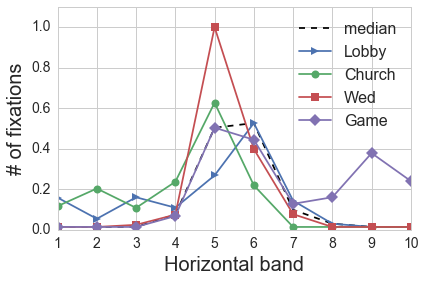

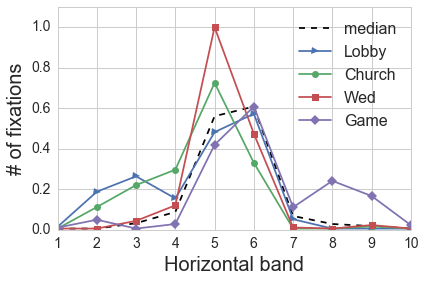

In [5]:
# Plotting fixation distribution
imageLabels = ['Lobby', 'Church', 'Wed','Game'];

N = len(imageLabels)
labels = imageLabels
ind = np.arange(10) # Images evaluated every 10%
indLabels = np.arange(1, 11, 1)
# String with the fixations
#s = "[2442         837        2469        1677        4128        8097        2211         462         216         216; 1794        3132        1665        3645        9642        3372         216         216         216         216; 219         216         216         306        8739        8631        1518        1071         216         216; 219         216         216        1284        9690        8745        2652         495         216         216; 219         216         216         216        3000        9630        4632         837         216         882; 219         216         378        1149       15375        6129        1185         216         216         216; 219         216         576        1812        3837       10131        2514        1938        1488        3096; 219         876         216         600        6048        7635        3018        2112         216         216; 219         216        1620         525        9168        9564         378         216         216         216; 219         216         216        1851       11454        9681         774         363         477         216; 2055         300         216         564        6579        9156        1509         216         387        2721; 219         303         942        4011        6471        2619        1437        3153        2544        1311; 219         447         285         216       10020       12060         912         216         216         216; 3177        4857         732         837        6606        5436         732         570        2025        2529; 219         216         216         216        4329       11367        4113        1359         864         216; 219         216         216        1398        8448        7194         837         945         216         216; 219         216         216        1467        7470        7698        2049         216        1908        1260; 219         216         216        1473       12060        5064        2670         216         216         216; 219         216         216        1041        7746        6834        1971        2472        5817        3696; 219         216         990        4668        9810        2985        1401         216         216         216; 219         216         828         402        3960        8442        2343         216        1497         216] "

s1 = "[ 2442         837        2469        1677        4128        8097        2211         462         216         216; 1794        3132        1665        3645        9642        3372         216         216         216         216; 219         216         378        1149       15375        6129        1185         216         216         216; 219         216         216        1041        7746        6834        1971        2472        5817        3696]"
#s2 = "[628.1    656.0    612.4    1398.0    7837.1    7641.4    1860.6    843.9    933.3    881.9]" #mean
s2 = "[219         216         216        1149        7746        8097        1518         462         216         216]" #median

fixations10_plot = mag_func(s1);
mean_fixations10 = mag_func(s2);

s3 = "[522        6663        9357        5487       17088       20298        1845         216         216         216; 219        3975        7824       10515       25710       11721         216         216         591         216; 219         216        1572        4275       35445       16809         408         216         831         216; 384        1761         216        1008       14871       21558        3945        8565        5910         813]"
#s4 = "[241    901    2066    3899    19469    22260    3189    1806    1401    450]" #mean
s4 = "[219         216        1152        3123       19875       21558        2415        1014         651         216]"#median

s5="[ 2844.2    1706.9    2080.1    1912.0    2304.6    1963.5    1465.5    1895.5    1562.0    1545.3]"

fixations20_plot = mag_func(s3);
mean_fixations20 = mag_func(s4);
mean_fixations20_x = mag_func(s5);

temp= fixations10_plot;
fixations10_plot = fixations10_plot/fixations10_plot.max()
mean_fixations10= mean_fixations10/temp.max()


temp= fixations20_plot;
# fixations20_plot = (fixations20_plot- fixations20_plot.min())/(fixations20_plot.max()- fixations20_plot.min())
# mean_fixations20= (mean_fixations20 - mean_fixations20.min())/(temp.max() -temp.min())

fixations20_plot = (fixations20_plot)/(fixations20_plot.max())
mean_fixations20= (mean_fixations20 )/(temp.max())
mean_fixations20_x= (mean_fixations20_x )/(temp.max())

colors = cycle(['steelblue', 'indianred', 'olivedrab','darkorange'])  
markers = np.array([">", "o", "s", "D", "d", "p"])

# Plot of 10s
fig=plt.figure()
plt.style.use('seaborn-whitegrid') 
plt.plot(ind, mean_fixations10[0], 'k--', label = 'median')

for i, color in zip(range(N), colors):
    plt.plot(ind, fixations10_plot[i], marker = markers[i], markersize=8, label='%s' % imageLabels[i])

plt.xlabel('Horizontal band', fontsize=20)
plt.ylabel('# of fixations',fontsize=20)
plt.ylim([0,1.10])
plt.xticks(ind, indLabels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.tight_layout()
#plt.show()
fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/Fixation_distribution10s_white.pdf', bbox_inches='tight')

# Plot of 20s
fig=plt.figure()
plt.plot(ind, mean_fixations20[0], 'k--', label = 'median')
#plt.plot(ind, mean_fixations20_x[0], 'k-', label = 'mean')
for i, color in zip(range(N), colors):
    plt.plot(ind, fixations20_plot[i], marker = markers[i], markersize=7, label='%s' % imageLabels[i])

plt.xlabel('Horizontal band', fontsize=20)
plt.ylabel('# of fixations',fontsize=20)

plt.ylim([0,1.10])
plt.xticks(ind, indLabels)
plt.xticks(ind, indLabels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.tight_layout()
#plt.show()
fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/Fixation_distribution20s_white.pdf', bbox_inches='tight')


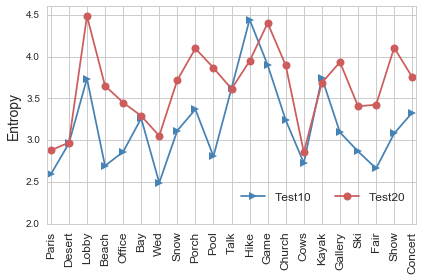

In [6]:
# Plotting entropy
imageLabels = ['Paris', 'Desert', 'Lobby', 'Beach', 'Office', 'Bay', 'Wed', 'Snow', 'Porch', 'Pool', 'Talk', 'Hike', 'Game', 'Church', 'Cows', 'Kayak', 'Gallery', 'Ski', 'Fair', 'Show', 'Concert']

N = len(imageLabels)
labels = ['Test10', 'Test20']
ind = np.arange(N)
T=2

colors = np.array(['steelblue', 'indianred', 'olivedrab','darkorange',  'magenta', 'cornflowerblue', 'magenta', 'salmon'])  
markers = np.array([">", "o", "s", "D", "d", "p"])

#eps= 3
# E = "[ 3.0488    2.6877    2.2423    2.1776    2.5205    2.3108    3.3392    2.4982    2.3369    2.4238    2.9503    3.3312    1.9963    3.8147    2.2981    2.2083    2.5597    2.3493    3.5168    2.6718    2.7052; 3.9530    3.7066    3.2083    2.4961    3.1128    2.7992    3.4991    3.4344    3.6343    2.9246    3.0463    3.2697    2.4265    3.5073    2.5982    2.9828    3.1914    3.2512    3.8075    3.3776    3.5976]"
# entropies = mag_func(E);

# # Plot of 10s
# fig=plt.figure()
# #plt.plot(ind, mean_fixations10[0], 'k--', label = 'mean')
# for i, color in zip(range(T), colors):
#     plt.plot(ind, entropies[i], marker = markers[i], markersize=7, label='%s' % labels[i])
# plt.xticks(ind, imageLabels, rotation=90)
# plt.ylabel('Entropy',fontsize=12)
# plt.legend()

#eps= 6
#E = "[   3.5673    3.2574    2.6460    2.5520    2.7761    2.4864    3.6334    2.9789    2.9659    2.6756    3.1930    3.9104    2.6645    4.3792    2.9425    2.8185    3.3172    2.7304    3.8530    3.1441    3.2760; 4.4861    3.8957    3.6512    2.8788    3.4510    3.0521    3.6141    4.1068    3.9350    3.4237    3.2912    3.6864    2.8570    3.9464    2.9723    3.4069    3.7549    3.8661    4.4013    3.7184    4.0978]"

E= "[2.5918    2.9617    3.7360    2.6941    2.8600    3.2613    2.4914    3.1154    3.3685    2.8077    3.6211    4.4438    3.8995    3.2401    2.7267    3.7457    3.0942    2.8661    2.6623    3.0807    3.3298; 2.8788    2.9723    4.4861    3.6512    3.4510    3.2912    3.0521    3.7184    4.0978    3.8661    3.6141    3.9464    4.4013    3.8957    2.8570    3.6864    3.9350    3.4069    3.4237    4.1068    3.7549]"

entropies = mag_func(E);

# Plot of 10s
fig=plt.figure()
plt.style.use('seaborn-whitegrid') 

#plt.plot(ind, mean_fixations10[0], 'k--', label = 'mean')
for i in range(T):
    plt.plot(  ind, entropies[i], marker = markers[i], color= colors[i], markersize=8, label='%s' % labels[i])

plt.xticks(ind, imageLabels, rotation=90,fontsize=12)
plt.ylim(2,4.6)
plt.ylabel('Entropy',fontsize=14)
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.05),fontsize=12, ncol=2)
#plt.gca().set_aspect('equal', adjustable='box')

plt.margins(0.01)
plt.tight_layout()
#plt.gca().axes.set_yticklabels([])

fig.savefig('C:/Users/Ana/Code/webvr-samples-master/panorama-viewer-master/Saliency/Entropy_white.pdf')

